# AbstractSolver

This is user level application logic to define a Solver

You give it a list of transformation functions to try, and a collection of
argument literals or argument generating functions. The codes inspect to figure out
the function signatures, and generates all typesafe permutations of `functions(arguments(arguments))`

These can either be solved to exhaustion, or short-circuited to only return the first valid rule
that passes the `problem['train']` dataset.

This is still early stage code, but I think I have proved the concept
of a brute-force IoC Dependency Injection Solver

```
class AbstractOutputGridSizeSolver(AbstractSolver):
    dtype: Tuple[int,int]
    functions = [
        OutputGridSizeTransforms.identity,
        OutputGridSizeTransforms.fixed_size,
        OutputGridSizeTransforms.ratio,
    ]
    arguments = [
        Query.grid_size_ratio_task,
        Query.count_nonzero,
        Query.unique_colors,
        1/4, 1/3, 1/2, 1, 2, 3, 4,
    ]
    def preprocess( self, input: np.ndarray ) -> Any:
        return input.shape
```

API Imports

In [1]:
import time
from collections import defaultdict
from itertools import chain
from pprint import pprint
from IPython.core.display import display
from src_james.DataModel import Competition, Task
from src_james.plot import plot_task
from src_james.settings import settings
from src_james.solvers.AbstractSolver import AbstractOutputGridSizeSolver
from src_james.solvers.Context import Context

%load_ext autoreload
%autoreload 2

# Solve for a single named task

We find 3 possible rule matches

In [2]:
solver = AbstractOutputGridSizeSolver()
task   = Task('evaluation/68b67ca3.json')
rule   = solver.solve(task)
rule


[<Rule fixed_size(size=3)>,
 <Rule ratio(input=input ratio=0.5)>,
 <Rule ratio(input=0 ratio=0.5)>]

# Performance

It's a little bit slow, 7.5s to iterate over the entire competition dataset
for a single really simply solver. Maybe performance is acceptable with a 9h submit timeout.

I've also not run a profiler on this yet, and some creative caching might help significantly.

In [3]:
time_start   = time.perf_counter()
competition  = Competition()
solutions    = defaultdict(list)
solved_files = { name: [] for name in competition.keys() }
error_files  = { name: [] for name in competition.keys() }
counts       = defaultdict(int)
totals       = defaultdict(int)
for name, dataset in competition.items():
    for task in dataset:
        totals[name] += 1

        #rule  = solver.solve_one(task)
        rules = solver.solve(task)
        if not len(rules):
            error_files[name].append(task.filename)
        else:
            solutions[task.filename] += rules
            solved_files[name].append(task.filename)
            counts[name] += 1

print(f"Time Taken: {round(time.perf_counter() - time_start,2)}s")

Time Taken: 12.28s


In [4]:
print()
print('Counts')
pprint(dict(counts))
pprint(dict(totals))



Counts
{'evaluation': 322, 'test': 78, 'training': 325}
{'evaluation': 400, 'test': 100, 'training': 400}


In [5]:
solved_filenames = list(chain(*solved_files.values()))
error_filenames  = list(chain(*error_files.values()))

print('Success: ', len(solved_filenames), '/', len(solved_filenames)+len(error_filenames))
print('Errors:  ', len(error_filenames),  '/', len(solved_filenames)+len(error_filenames))

Success:  725 / 900
Errors:   175 / 900


# Viewing discovered rules

With only 6 functions and 7 literals, it was possible to correctly predict the output grid size
in about 80% of cases.

In many cases it managed to find multiple valid rules for each task.
Unsure if there needs to be some prioritization over rules, or if we simply need to deduplicate
the set of all possible valid rules.

In [6]:
settings['debug'] = False  # some rules throw exceptions when called with different data in context
print('Solutions')
print()
for filename, matching_rules in list(solutions.items())[:5]:
    if len(matching_rules):
        print(filename)
        task = Task(filename)

        for rule in matching_rules:
            for test_problem in task['test']:
                guess = rule(Context(test_problem, test_problem['input']))
                print(f"{rule} -> {guess}")
        print()

Solutions

training/007bbfb7.json
<Rule ratio(input=input ratio=3)> -> (9, 9)
<Rule ratio(input=input ratio=0)> -> None
<Rule ratio(input=0 ratio=3)> -> (9, 9)
<Rule ratio(input=0 ratio=0)> -> None

training/00d62c1b.json
<Rule identity(input=0)> -> None
<Rule fixed_size(size=0)> -> None
<Rule ratio(input=input ratio=unique_colors)> -> (20, 20)
<Rule ratio(input=input ratio=1)> -> (20, 20)
<Rule ratio(input=input ratio=grid_size_ratio_task)> -> (20, 20)
<Rule ratio(input=0 ratio=unique_colors)> -> (20, 20)
<Rule ratio(input=0 ratio=1)> -> (20, 20)
<Rule ratio(input=0 ratio=grid_size_ratio_task)> -> (20, 20)

training/025d127b.json
<Rule identity(input=0)> -> None
<Rule fixed_size(size=0)> -> None
<Rule ratio(input=input ratio=1)> -> (10, 10)
<Rule ratio(input=input ratio=grid_size_ratio_task)> -> (10, 10)
<Rule ratio(input=0 ratio=1)> -> (10, 10)
<Rule ratio(input=0 ratio=grid_size_ratio_task)> -> (10, 10)

training/045e512c.json
<Rule identity(input=0)> -> None
<Rule fixed_size(size=0

## Successes

These are the first 5 examples of the problems that AbstractOutputGridSizeSolver couldn't figure out

[<Rule ratio(input=input ratio=3)>,
 <Rule ratio(input=input ratio=0)>,
 <Rule ratio(input=0 ratio=3)>,
 <Rule ratio(input=0 ratio=0)>]

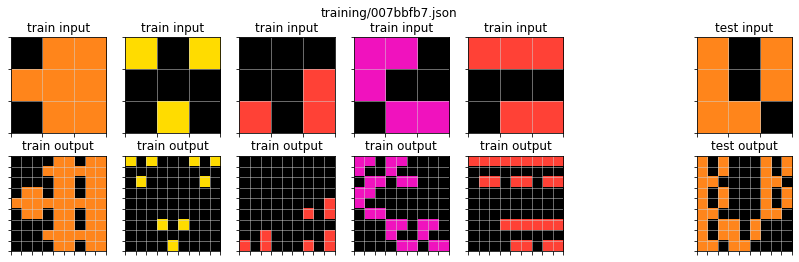

[<Rule identity(input=0)>,
 <Rule fixed_size(size=0)>,
 <Rule ratio(input=input ratio=unique_colors)>,
 <Rule ratio(input=input ratio=1)>,
 <Rule ratio(input=input ratio=grid_size_ratio_task)>,
 <Rule ratio(input=0 ratio=unique_colors)>,
 <Rule ratio(input=0 ratio=1)>,
 <Rule ratio(input=0 ratio=grid_size_ratio_task)>]

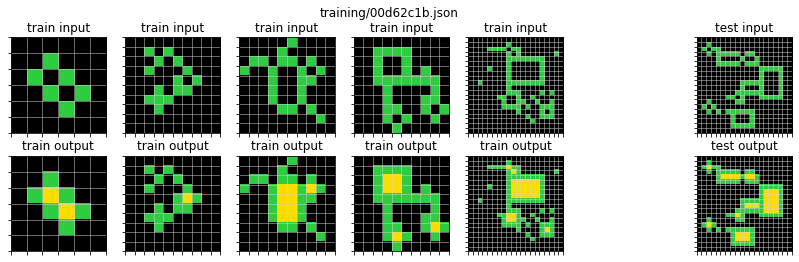

[<Rule identity(input=0)>,
 <Rule fixed_size(size=0)>,
 <Rule ratio(input=input ratio=1)>,
 <Rule ratio(input=input ratio=grid_size_ratio_task)>,
 <Rule ratio(input=0 ratio=1)>,
 <Rule ratio(input=0 ratio=grid_size_ratio_task)>]

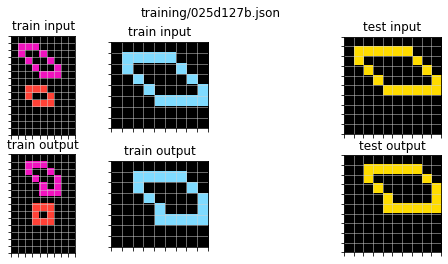

[<Rule identity(input=0)>,
 <Rule fixed_size(size=0)>,
 <Rule ratio(input=input ratio=1)>,
 <Rule ratio(input=input ratio=grid_size_ratio_task)>,
 <Rule ratio(input=0 ratio=1)>,
 <Rule ratio(input=0 ratio=grid_size_ratio_task)>]

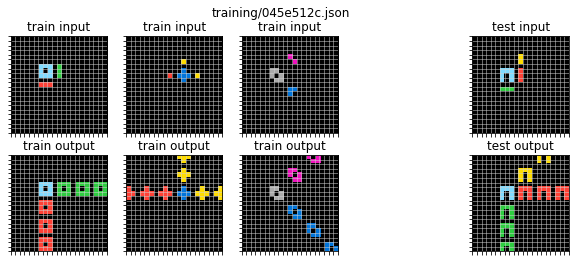

[<Rule fixed_size(size=3)>]

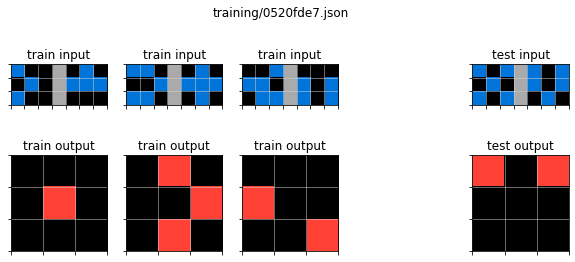

In [7]:
print('Success: ', len(solved_filenames), '/', len(solved_filenames)+len(error_filenames))

for filename in solved_filenames[:5]:
    task = Task(filename)
    display(solver.solve(task))
    plot_task(task)


## Failures

These are the first 5 examples of the problems that AbstractOutputGridSizeSolver couldn't figure out

In [ ]:
print('Errors:  ', len(error_filenames),  '/', len(solved_filenames)+len(error_filenames))
for filename in error_filenames[:5]:
    plot_task(Task(filename))
